In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


#### **Import the required dependencies**

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
file=pd.read_csv(r'/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

#### **Load the Dataset**

In [3]:
file.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### **Now, lets look into the background of the dataset and make required changes, if needed.**

In [4]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## **Data Cleaning & Preprocessing**
---

#### **Based on info. available for the features, '_step_' column seems to be a datetime column, so it is required to keep our dataset according to the step column so that we can look into it later, to understand the effect of time on our target variable**

In [5]:
file=file.sort_values(by='step', ascending=True)

#### **Before we move forward, let's check if we have any '_duplicates_' or '_Nan_'in any of the columns**

In [6]:
print(file.isna().sum())
print("*"*20)
print(file.duplicated().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
********************
0


In [7]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6362620 entries, 2129 to 6362612
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


#### **As we have noticed regarding the '_step_' column, now, let's take an imaginary date and give the '_step_' column a proper form of a '_datetime_' column so that we can engineer some feature and investigate the time component with the target variable.**

In [8]:
i_date=pd.to_datetime("2010-01-01 00:00:00")
file['datetime']=i_date+pd.to_timedelta(file['step'], unit='h')
file=file.sort_values('datetime').reset_index(drop=True)

#### **'_isFlaggedFraud_' column seems to be a subsidiary column of '_isFraud_' column, which highlights high-value frauds, whereas our target is to predict which transactions seem to be fraud despite the amount, so let's remove the column.**

In [9]:
file.drop(columns=['isFlaggedFraud'], inplace=True)
file.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,datetime
0,1,CASH_IN,42012.45,C1137667747,350501.24,350501.24,C667346055,350501.24,9291619.62,0,2010-01-01 01:00:00
1,1,PAYMENT,106.81,C1810518740,0.00,0.00,M295180183,0.00,0.00,0,2010-01-01 01:00:00
2,1,PAYMENT,6297.71,C1547883191,762.00,0.00,M1650113431,0.00,0.00,0,2010-01-01 01:00:00
3,1,PAYMENT,2610.01,C1528769018,58697.54,56087.54,M183155105,0.00,0.00,0,2010-01-01 01:00:00
4,1,PAYMENT,5320.10,C1089930529,56087.54,50767.43,M2001115307,0.00,0.00,0,2010-01-01 01:00:00


#### **Now let's split our data into two halves, one for training and another for testing, using a specific date, it will prevent data leakage.**

In [10]:
cutoff_date=pd.to_datetime('2010-01-22')
train=file[file['datetime']<cutoff_date].copy()
test=file[file['datetime']>=cutoff_date].copy()

In [11]:
train.shape, test.shape

((6064026, 11), (298594, 11))

### **Exploratory Data Analysis (EDA)**
---

#### **We will run some deep analysis on our dataset to get a broader understanding and will make our strategies based on our understanding. So, let's make a shallow copy of our dataset to avoid any changes to the original set.**

In [12]:
file1=train.copy()

#### **Let's look into the unique count of the variables in our dataset.**

In [13]:
for i in file1.columns:
    print(file1[i].value_counts())
    print("*"*40)

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
293        4
114        4
124        4
28         4
112        2
Name: count, Length: 503, dtype: int64
****************************************
type
CASH_OUT    2141476
PAYMENT     2047519
CASH_IN     1331163
TRANSFER     504877
DEBIT         38991
Name: count, dtype: int64
****************************************
amount
10000000.00    3067
10000.00         88
5000.00          78
15000.00         68
500.00           65
               ... 
237622.38         1
454022.54         1
151293.50         1
87544.18          1
390476.45         1
Name: count, Length: 5106802, dtype: int64
****************************************
nameOrig
C1784010646    3
C1999539787    3
C1976208114    3
C545315117     3
C363736674     3
              ..
C1673426665    1
C695226568     1
C1541439199    1
C1546763893    1
C1596719999    1
Name: count, Length: 6055541, dtype: int64
****************************************
oldbalanc

In [14]:
file1.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,datetime
count,6.064026e+06,6.064026e+06,6.064026e+06,6.064026e+06,6.064026e+06,6.064026e+06,6.064026e+06,6064026
mean,2.260044e+02,1.803189e+05,8.421815e+05,8.638916e+05,1.097152e+06,1.223099e+06,9.252929e-04,2010-01-10 10:00:15.897755136
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2010-01-01 01:00:00
25%,1.530000e+02,1.347164e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2010-01-07 09:00:00
50%,2.330000e+02,7.512099e+04,1.385883e+04,0.000000e+00,1.348696e+05,2.170280e+05,0.000000e+00,2010-01-10 17:00:00
75%,3.270000e+02,2.090807e+05,1.071720e+05,1.440681e+05,9.463474e+05,1.116713e+06,0.000000e+00,2010-01-14 15:00:00
max,5.030000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,2010-01-21 23:00:00
std,1.208996e+02,6.101631e+05,2.921357e+06,2.957898e+06,3.359632e+06,3.647093e+06,3.040455e-02,NaN


In [15]:
file1.describe(include='O')

,type,nameOrig,nameDest
count,6064026,6064026,6064026
unique,5,6055541,2589528
top,CASH_OUT,C1784010646,C1286084959
freq,2141476,3,113


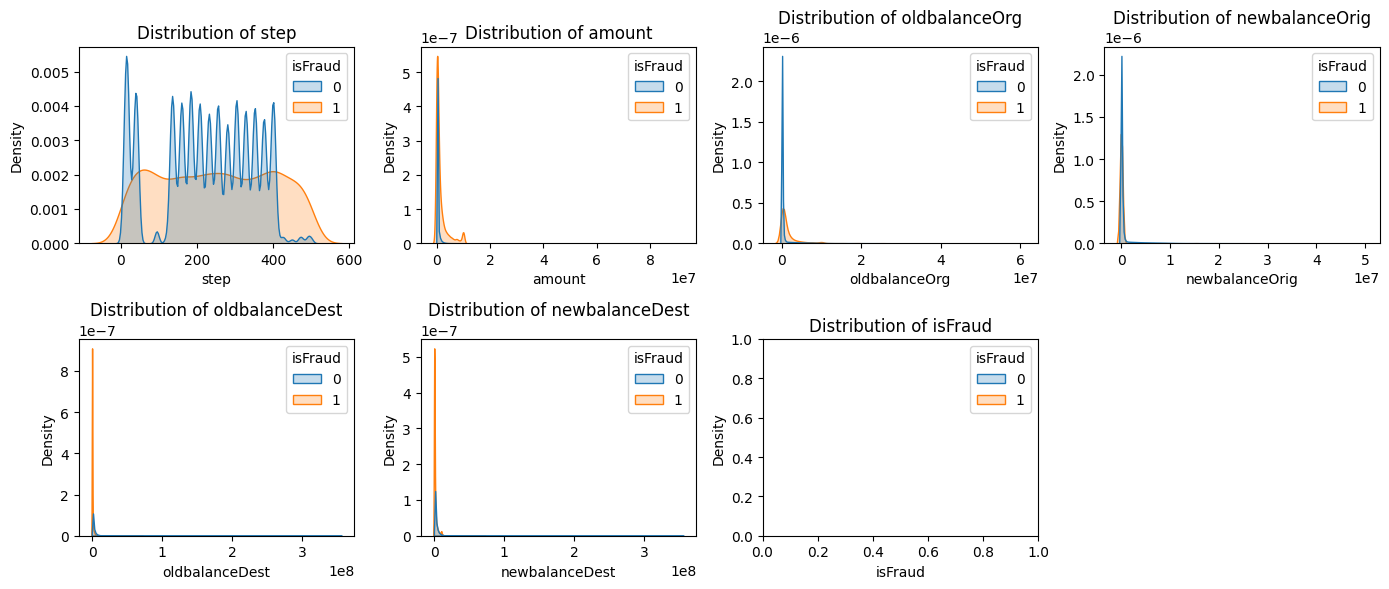

In [16]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, col in enumerate(file1.select_dtypes(include='number')):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(data=file1, x=col, hue="isFraud", common_norm=False, fill=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

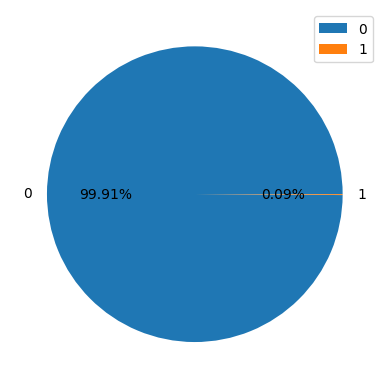

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.pie(file1['isFraud'].value_counts(), labels=file1['isFraud'].value_counts().index, autopct="%0.2f%%")
plt.legend()
plt.show()

In [18]:
file1_v=file1.copy()

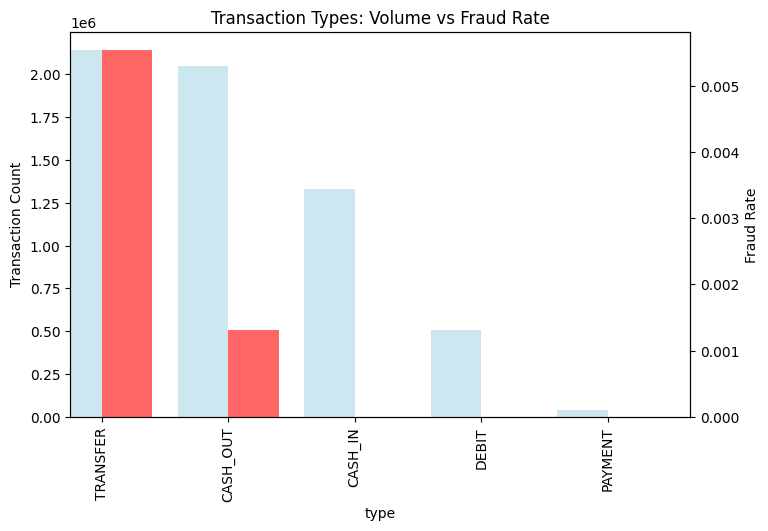

In [19]:
fraud_rate = file1_v.groupby('type')['isFraud'].mean().sort_values(ascending=False)
t_type_counts = file1_v['type'].value_counts()

fig, ax1 = plt.subplots(figsize=(8,5))

ax2 = ax1.twinx()
t_type_counts.plot(kind='bar', ax=ax1, color='lightblue', alpha=0.6, width=0.4, position=1)
fraud_rate.plot(kind='bar', ax=ax2, color='red', alpha=0.6, width=0.4, position=0)

ax1.set_ylabel("Transaction Count")
ax2.set_ylabel("Fraud Rate")
plt.title("Transaction Types: Volume vs Fraud Rate")
plt.show()

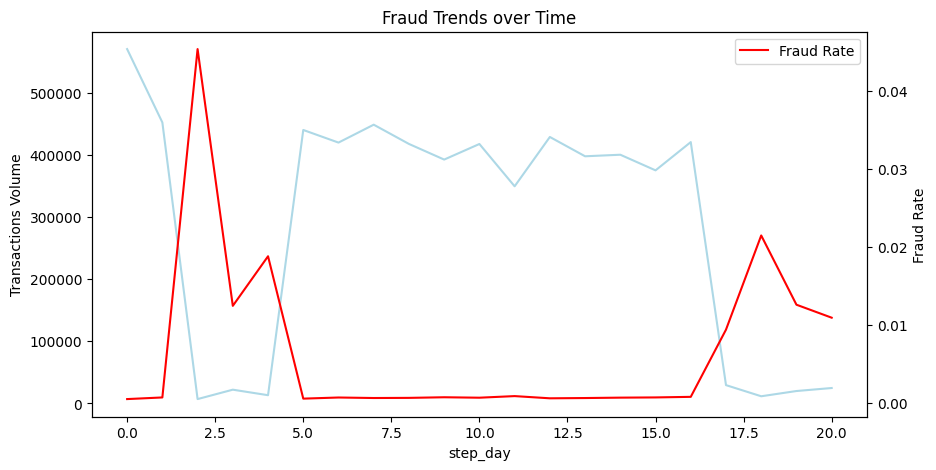

In [20]:
file1_v['step_day'] = file1_v['step'] // 24  # convert hours to days

fraud_by_day = file1_v.groupby('step_day')['isFraud'].mean()
volume_by_day = file1_v.groupby('step_day')['isFraud'].count()

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

volume_by_day.plot(ax=ax1, color='lightblue', label="Volume")
fraud_by_day.plot(ax=ax2, color='red', label="Fraud Rate")

ax1.set_ylabel("Transactions Volume")
ax2.set_ylabel("Fraud Rate")
plt.title("Fraud Trends over Time")
plt.legend()
plt.show()

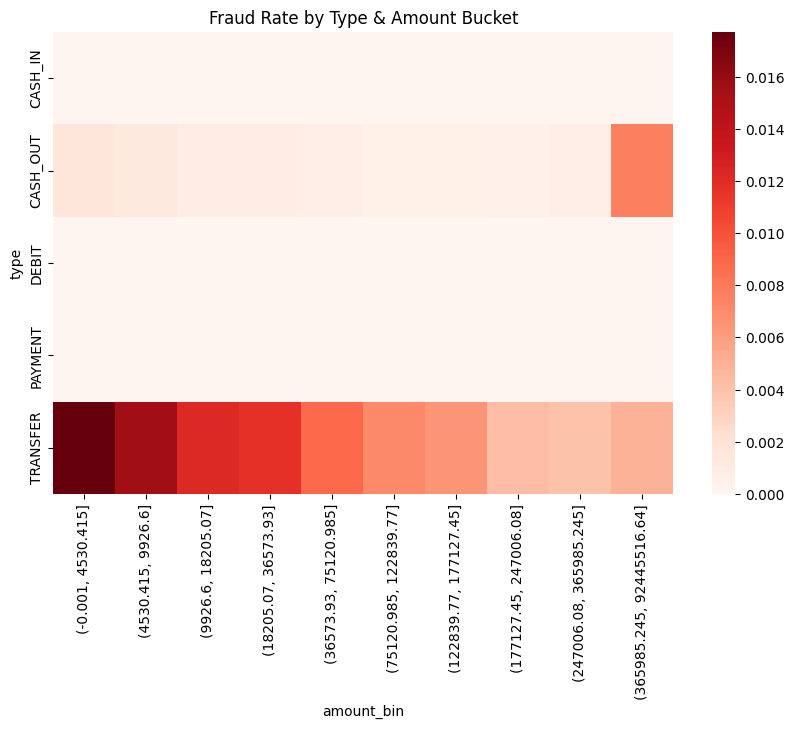

In [21]:
file1_v['amount_bin'] = pd.qcut(file1_v['amount'], q=10, duplicates="drop")
cross_tab = file1_v.groupby(['type','amount_bin'])['isFraud'].mean().unstack().fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(cross_tab, cmap="Reds", annot=False, cbar=True)
plt.title("Fraud Rate by Type & Amount Bucket")
plt.show()

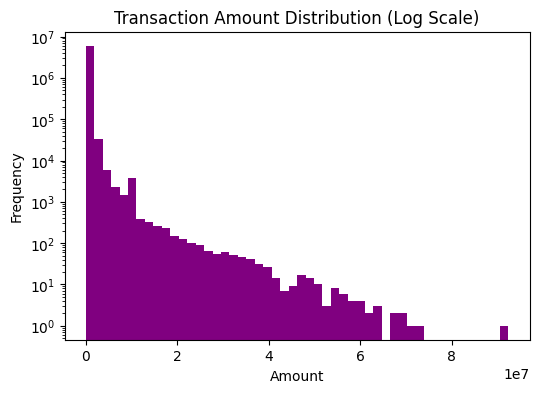

In [22]:
plt.figure(figsize=(6,4))
file1_v['amount'].plot(kind='hist', bins=50, log=True, color='purple')
plt.title("Transaction Amount Distribution (Log Scale)")
plt.xlabel("Amount")
plt.show()

## **Feature Engineering**
---

#### **Now, we have some understanding of the dataset, like where and when this fraud is happening, how much the fraud is happening, considering the transaction volume. Now, let's try to engineer some features so that our model can get some relevance about the fraudsters.**

In [23]:
file1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6064026 entries, 0 to 6064025
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   step            int64         
 1   type            object        
 2   amount          float64       
 3   nameOrig        object        
 4   oldbalanceOrg   float64       
 5   newbalanceOrig  float64       
 6   nameDest        object        
 7   oldbalanceDest  float64       
 8   newbalanceDest  float64       
 9   isFraud         int64         
 10  datetime        datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 555.2+ MB


In [24]:
def datetime_component(df, datetime_col='datetime'):
    df=df.copy()
    df['hour']=df['datetime'].dt.hour
    df['day']=df['datetime'].dt.day
    df['weekday']=df['datetime'].dt.weekday
    return df

In [25]:
file2 = datetime_component(file1, datetime_col='datetime')
file2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,datetime,hour,day,weekday
0,1,CASH_IN,42012.45,C1137667747,350501.24,350501.24,C667346055,350501.24,9291619.62,0,2010-01-01 01:00:00,1,1,4
1,1,PAYMENT,106.81,C1810518740,0.00,0.00,M295180183,0.00,0.00,0,2010-01-01 01:00:00,1,1,4
2,1,PAYMENT,6297.71,C1547883191,762.00,0.00,M1650113431,0.00,0.00,0,2010-01-01 01:00:00,1,1,4
3,1,PAYMENT,2610.01,C1528769018,58697.54,56087.54,M183155105,0.00,0.00,0,2010-01-01 01:00:00,1,1,4
4,1,PAYMENT,5320.10,C1089930529,56087.54,50767.43,M2001115307,0.00,0.00,0,2010-01-01 01:00:00,1,1,4


In [26]:
file2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6064026 entries, 0 to 6064025
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   step            int64         
 1   type            object        
 2   amount          float64       
 3   nameOrig        object        
 4   oldbalanceOrg   float64       
 5   newbalanceOrig  float64       
 6   nameDest        object        
 7   oldbalanceDest  float64       
 8   newbalanceDest  float64       
 9   isFraud         int64         
 10  datetime        datetime64[ns]
 11  hour            int32         
 12  day             int32         
 13  weekday         int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(2), object(3)
memory usage: 624.6+ MB


In [27]:
import cudf

def some_new_features(df, amount_col='amount', orig_col='nameOrig', dest_col='nameDest', old_orig_bal='oldbalanceOrg', new_orig_bal='newbalanceOrig', old_dest_bal='oldbalanceDest', new_dest_bal='newbalanceDest'):

    df['log_amount']=np.log1p(df['amount'])
    ddf=cudf.from_pandas(df)
    
    ddf['nameOrig'] = ddf['nameOrig'].astype(str)
    ddf['nameDest'] = ddf['nameDest'].astype(str)
    
    ddf['nameOrig_count'] = ddf.groupby('nameOrig').cumcount()
    c_nameOrig_count=ddf['nameOrig_count'].replace(0, 1)
    ddf['nameOrig_avg_amount'] = (ddf.groupby('nameOrig')['amount'].cumsum().shift(1).fillna(0) / c_nameOrig_count).fillna(0)
    
    ddf['nameDest_count']=ddf.groupby('nameDest').cumcount()
    c_nameDest_count=ddf['nameDest_count'].replace(0, 1)
    ddf['nameDest_avg_amount'] = (ddf.groupby('nameDest')['amount'].cumsum().shift(1).fillna(0) / c_nameDest_count).fillna(0)
    
    ddf['deltaOrig'] = ddf['oldbalanceOrg'] - ddf['newbalanceOrig'] - ddf['amount']
    ddf['deltaDest'] = ddf['newbalanceDest'] - ddf['oldbalanceDest'] - ddf['amount']
    
    ddf['orig_balance_zero'] = ((ddf['oldbalanceOrg'] == 0) & (ddf['amount'] > 0)).astype('int32')
    ddf['dest_balance_zero'] = ((ddf['oldbalanceDest'] == 0) & (ddf['amount'] > 0)).astype('int32')
    ddf['no_balance_change'] = (ddf['oldbalanceOrg'] == ddf['newbalanceOrig']).astype('int32')
    
    sender=ddf.groupby('nameOrig').agg(num_trx=('nameOrig', 'count')).reset_index()
    receiver=ddf.groupby('nameDest').agg(num_trx_f=('nameDest', 'count'), avg_amnt_f=('amount', 'mean')).reset_index()
    
    ddf=ddf.merge(sender, on='nameOrig', how='left')
    ddf=ddf.merge(receiver, on='nameDest', how='left')

    file3 = ddf.to_pandas()
    return file3

In [28]:
file3=some_new_features(file2, amount_col='amount', orig_col='nameOrig', dest_col='nameDest', old_orig_bal='oldbalanceOrg', new_orig_bal='newbalanceOrig', old_dest_bal='oldbalanceDest', new_dest_bal='newbalanceDest')
file3=file3.sort_values(by='datetime', ascending=True)
file3.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,datetime,hour,day,weekday,log_amount,nameOrig_count,nameOrig_avg_amount,nameDest_count,nameDest_avg_amount,deltaOrig,deltaDest,orig_balance_zero,dest_balance_zero,no_balance_change,num_trx,num_trx_f,avg_amnt_f
4834,1,PAYMENT,6396.49,C1389432760,458.0,0.00,M1103132232,0.00,0.00,0,2010-01-01 01:00:00,1,1,4,8.763661,0,17994.24,0,17994.24,-5.938490e+03,-6396.49,0,1,0,1,1,6396.490000
3322,1,PAYMENT,7292.16,C69673470,216827.0,209534.84,M1082411691,0.00,0.00,0,2010-01-01 01:00:00,1,1,4,8.894692,0,12986.61,0,12986.61,3.637979e-12,-7292.16,0,1,0,1,1,7292.160000
3323,1,CASH_OUT,64489.64,C146874094,0.0,0.00,C1297685781,398424.59,16997.22,0,2010-01-01 01:00:00,1,1,4,11.074275,0,7292.16,8,911.52,-6.448964e+04,-445917.01,1,0,1,1,76,554932.487632
3324,1,DEBIT,8727.74,C166694583,882770.0,874042.26,C1129670968,12636.00,0.00,0,2010-01-01 01:00:00,1,1,4,9.074376,0,64489.64,0,1051192.91,-9.094947e-12,-21363.74,0,0,0,1,52,464104.459423
3325,1,PAYMENT,6536.86,C416201381,17319.0,10782.14,M1178290888,0.00,0.00,0,2010-01-01 01:00:00,1,1,4,8.785365,0,8727.74,0,8727.74,9.094947e-13,-6536.86,0,1,0,1,1,6536.860000


In [29]:
def risk_type(df, main_col='type', high_risk=['TRANSFER', 'CASH_OUT']):
    
    df['is_high_risk_type'] = df['type'].isin(high_risk).astype(int)
    df=df.sort_values(by='datetime', ascending=True)
    df.drop(columns=['step', 'datetime', 'amount', 'type', 'nameOrig', 'nameDest', 'oldbalanceOrg', 'oldbalanceDest'], inplace=True)
    return df

In [30]:
file3=risk_type(file3, main_col='type', high_risk=['TRANSFER', 'CASH_OUT'])
file3.head()

,newbalanceOrig,newbalanceDest,isFraud,hour,day,weekday,log_amount,nameOrig_count,nameOrig_avg_amount,nameDest_count,nameDest_avg_amount,deltaOrig,deltaDest,orig_balance_zero,dest_balance_zero,no_balance_change,num_trx,num_trx_f,avg_amnt_f,is_high_risk_type
4834,0.00,0.00,0,1,1,4,8.763661,0,17994.24,0,17994.240000,-5.938490e+03,-6396.49,0,1,0,1,1,6396.490000,0
4838,921.76,424250.45,0,1,1,4,7.724111,0,8787.63,9,976.403333,0.000000e+00,-418231.70,0,0,0,1,42,283415.777381,0
11122,3113581.47,0.00,0,1,1,4,12.145471,0,205955.77,3,116397.343333,-3.764771e+05,-890687.75,0,0,0,1,35,222974.210571,0
4608,10357.33,0.00,0,1,1,4,6.891290,0,3735.16,0,3735.160000,1.136868e-13,-982.67,0,1,0,1,1,982.670000,0
4609,14375.74,0.00,0,1,1,4,9.155912,0,982.67,0,982.670000,0.000000e+00,-9469.26,0,1,0,1,1,9469.260000,0


In [31]:
file3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6064026 entries, 4834 to 6064025
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   newbalanceOrig       float64
 1   newbalanceDest       float64
 2   isFraud              int64  
 3   hour                 int32  
 4   day                  int32  
 5   weekday              int32  
 6   log_amount           float64
 7   nameOrig_count       int64  
 8   nameOrig_avg_amount  float64
 9   nameDest_count       int64  
 10  nameDest_avg_amount  float64
 11  deltaOrig            float64
 12  deltaDest            float64
 13  orig_balance_zero    int32  
 14  dest_balance_zero    int32  
 15  no_balance_change    int32  
 16  num_trx              int64  
 17  num_trx_f            int64  
 18  avg_amnt_f           float64
 19  is_high_risk_type    int64  
dtypes: float64(8), int32(6), int64(6)
memory usage: 832.8 MB


#### **Exploratory Data Analysis (EDA)**
---

#### We have finally created some features; now, lets look into our dataset again

In [32]:
file3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6064026 entries, 4834 to 6064025
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   newbalanceOrig       float64
 1   newbalanceDest       float64
 2   isFraud              int64  
 3   hour                 int32  
 4   day                  int32  
 5   weekday              int32  
 6   log_amount           float64
 7   nameOrig_count       int64  
 8   nameOrig_avg_amount  float64
 9   nameDest_count       int64  
 10  nameDest_avg_amount  float64
 11  deltaOrig            float64
 12  deltaDest            float64
 13  orig_balance_zero    int32  
 14  dest_balance_zero    int32  
 15  no_balance_change    int32  
 16  num_trx              int64  
 17  num_trx_f            int64  
 18  avg_amnt_f           float64
 19  is_high_risk_type    int64  
dtypes: float64(8), int32(6), int64(6)
memory usage: 832.8 MB


In [33]:
for i in file3.columns:
    print(file3[i].value_counts())
    print("*"*40)

newbalanceOrig
0.00          3447508
4471.89             4
10721.60            4
8927.38             4
8555.34             4
               ...   
118612.44           1
248294.69           1
56080.42            1
261505.04           1
5325362.37          1
Name: count, Length: 2553052, dtype: int64
****************************************
newbalanceDest
0.00           2320610
971418.91           32
10000000.00         29
19169204.93         29
16532032.16         25
                ...   
1789783.81           1
925900.29            1
521109.74            1
7317238.10           1
269244.96            1
Name: count, Length: 3379294, dtype: int64
****************************************
isFraud
0    6058415
1       5611
Name: count, dtype: int64
****************************************
hour
19    624921
18    538788
20    526711
12    462211
13    444752
11    434911
17    432447
14    415906
16    413379
10    411024
15    404163
9     274332
21    231057
22    178207
23    132904
0     

In [34]:
new_cols=['nameOrig_count', 'orig_balance_zero', 'dest_balance_zero', 'no_balance_change']

cont_cols=['hour', 'day', 'weekday', 'newbalanceOrig', 'newbalanceDest', 'log_amount', 'nameOrig_avg_amount', 'nameDest_count', 'nameDest_avg_amount', 'deltaOrig', 'deltaDest']

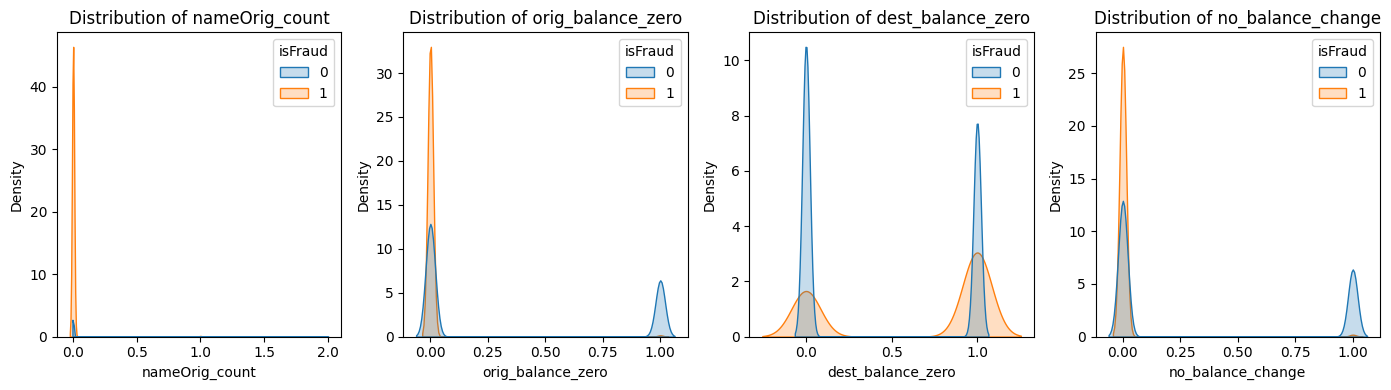

In [35]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(new_cols):
    plt.subplot(1, 4, i+1)
    sns.kdeplot(data=file3, x=col, hue="isFraud", common_norm=False, fill=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [36]:
for col in new_cols:
    print(f"\nFraud rate breakdown for: {col}")
    summary = (file3.groupby(col)['isFraud'].agg(['count', 'sum']).rename(columns={'count': 'Total_Txns', 'sum': 'Fraud_Txns'}))
    summary['Fraud_Rate'] = summary['Fraud_Txns'] / summary['Total_Txns']
    print(summary.sort_values('Fraud_Rate', ascending=False))
    print("*"*40)


Fraud rate breakdown for: nameOrig_count
                Total_Txns  Fraud_Txns  Fraud_Rate
nameOrig_count                                    
1                     8472          13    0.001534
0                  6055541        5598    0.000924
2                       13           0    0.000000
****************************************

Fraud rate breakdown for: orig_balance_zero
                   Total_Txns  Fraud_Txns  Fraud_Rate
orig_balance_zero                                    
0                     4046015        5586    0.001381
1                     2018011          25    0.000012
****************************************

Fraud rate breakdown for: dest_balance_zero
                   Total_Txns  Fraud_Txns  Fraud_Rate
dest_balance_zero                                    
1                     2570235        3639    0.001416
0                     3493791        1972    0.000564
****************************************

Fraud rate breakdown for: no_balance_change
             

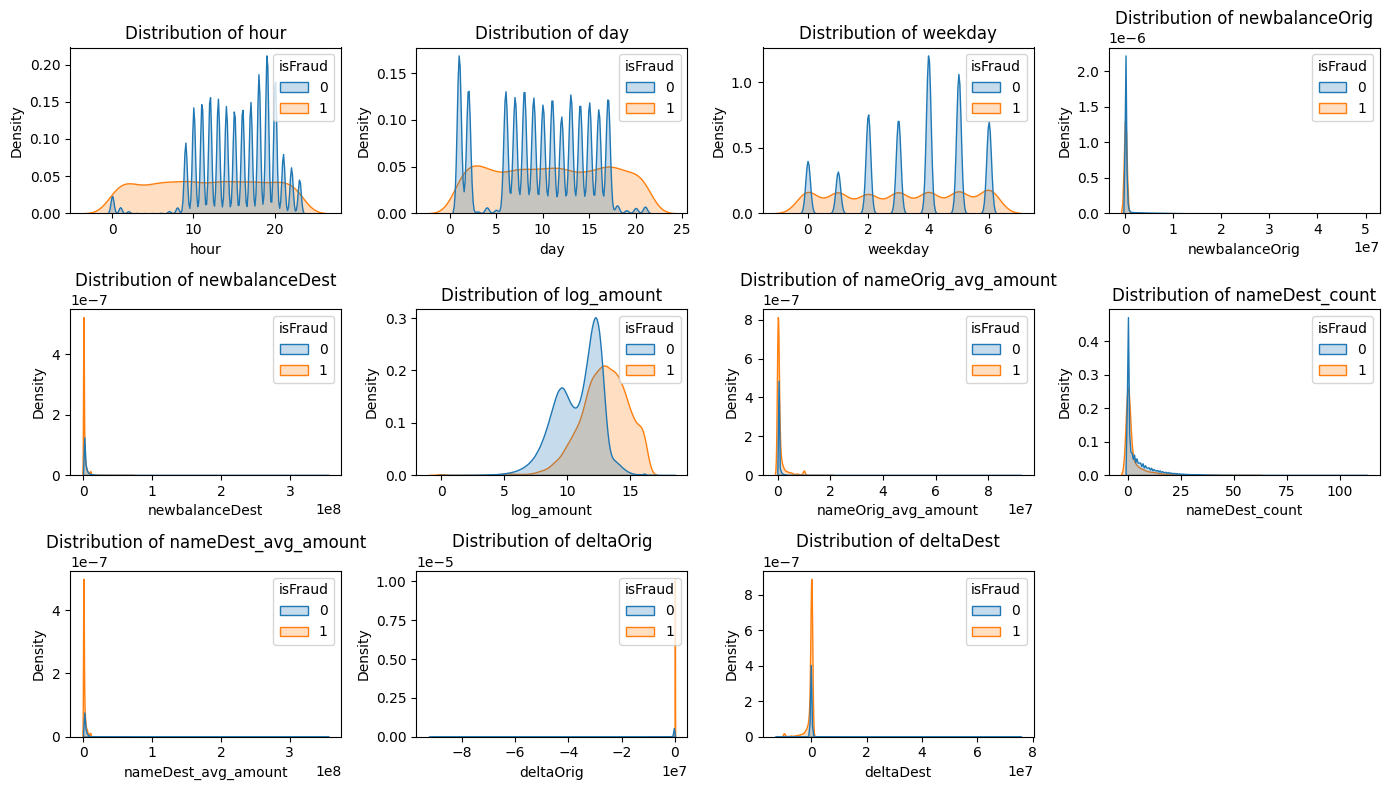

In [37]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(cont_cols):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(data=file3, x=col, hue="isFraud", common_norm=False, fill=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()  
plt.show()

In [38]:
w_f=file3.groupby('weekday')['isFraud'].mean()
w_f

weekday
0    0.001735
1    0.002090
2    0.000809
3    0.000932
4    0.000560
5    0.000656
6    0.001092
Name: isFraud, dtype: float64

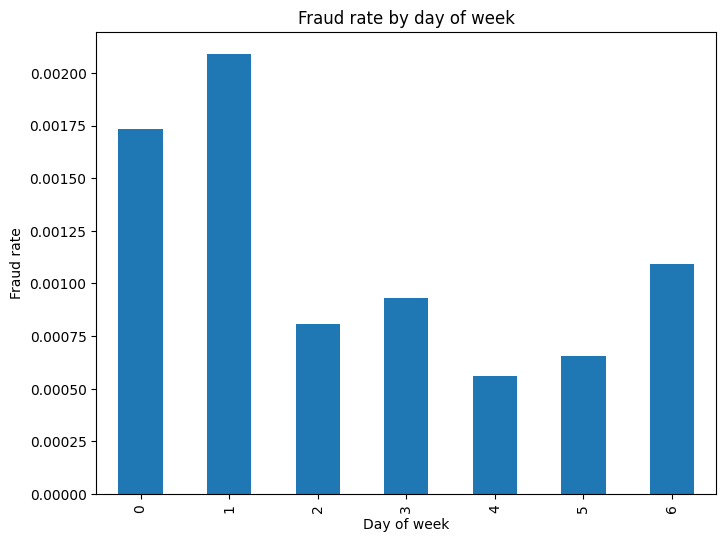

In [39]:
plt.figure(figsize=(8, 6))
w_f.plot(kind='bar')
plt.title('Fraud rate by day of week')
plt.xlabel('Day of week')
plt.ylabel('Fraud rate')
plt.show()

In [40]:
hourly=file3.groupby('hour')['isFraud'].sum()
hourly

hour
0     186
1     252
2     248
3     214
4     190
5     236
6     238
7     240
8     238
9     247
10    255
11    216
12    233
13    242
14    251
15    241
16    229
17    253
18    241
19    216
20    248
21    245
22    233
23    219
Name: isFraud, dtype: int64

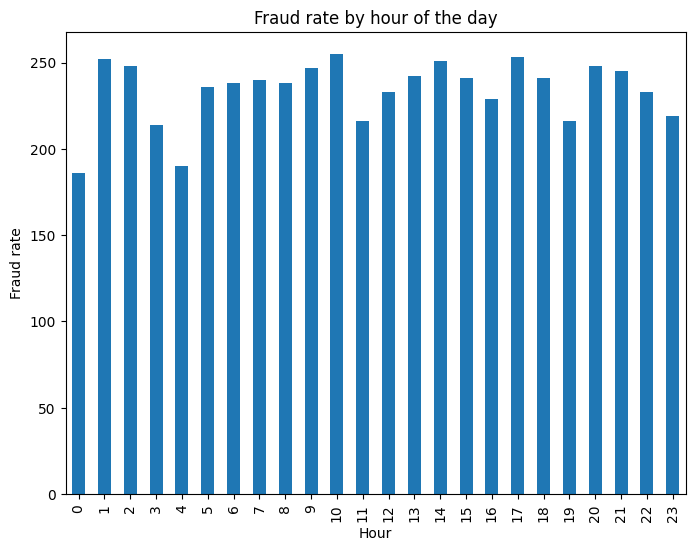

In [41]:
plt.figure(figsize=(8, 6))
hourly.plot(kind='bar')
plt.title('Fraud rate by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Fraud rate')
plt.show()

In [42]:
hourly_rate=file3.groupby('hour')['isFraud'].mean()
hourly_rate

hour
0     0.002734
1     0.010432
2     0.030262
3     0.146375
4     0.186275
5     0.190784
6     0.126866
7     0.027168
8     0.010129
9     0.000900
10    0.000620
11    0.000497
12    0.000504
13    0.000544
14    0.000604
15    0.000596
16    0.000554
17    0.000585
18    0.000447
19    0.000346
20    0.000471
21    0.001060
22    0.001307
23    0.001648
Name: isFraud, dtype: float64

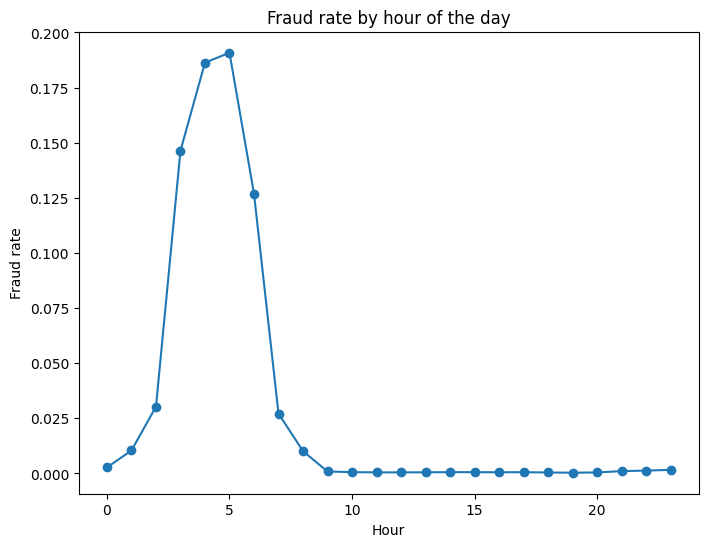

In [43]:
plt.figure(figsize=(8, 6))
hourly_rate.plot(kind='line', marker='o')
plt.title('Fraud rate by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Fraud rate')
plt.show()

*The above graph shows:
-Fraud activity peaked during the early morning hours, between 2AM and 7AM, with highest spike at 5AM
-From morning (after7AM) to late evening 

In [44]:
file3.head()

,newbalanceOrig,newbalanceDest,isFraud,hour,day,weekday,log_amount,nameOrig_count,nameOrig_avg_amount,nameDest_count,nameDest_avg_amount,deltaOrig,deltaDest,orig_balance_zero,dest_balance_zero,no_balance_change,num_trx,num_trx_f,avg_amnt_f,is_high_risk_type
4834,0.00,0.00,0,1,1,4,8.763661,0,17994.24,0,17994.240000,-5.938490e+03,-6396.49,0,1,0,1,1,6396.490000,0
4838,921.76,424250.45,0,1,1,4,7.724111,0,8787.63,9,976.403333,0.000000e+00,-418231.70,0,0,0,1,42,283415.777381,0
11122,3113581.47,0.00,0,1,1,4,12.145471,0,205955.77,3,116397.343333,-3.764771e+05,-890687.75,0,0,0,1,35,222974.210571,0
4608,10357.33,0.00,0,1,1,4,6.891290,0,3735.16,0,3735.160000,1.136868e-13,-982.67,0,1,0,1,1,982.670000,0
4609,14375.74,0.00,0,1,1,4,9.155912,0,982.67,0,982.670000,0.000000e+00,-9469.26,0,1,0,1,1,9469.260000,0


In [45]:
file3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6064026 entries, 4834 to 6064025
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   newbalanceOrig       float64
 1   newbalanceDest       float64
 2   isFraud              int64  
 3   hour                 int32  
 4   day                  int32  
 5   weekday              int32  
 6   log_amount           float64
 7   nameOrig_count       int64  
 8   nameOrig_avg_amount  float64
 9   nameDest_count       int64  
 10  nameDest_avg_amount  float64
 11  deltaOrig            float64
 12  deltaDest            float64
 13  orig_balance_zero    int32  
 14  dest_balance_zero    int32  
 15  no_balance_change    int32  
 16  num_trx              int64  
 17  num_trx_f            int64  
 18  avg_amnt_f           float64
 19  is_high_risk_type    int64  
dtypes: float64(8), int32(6), int64(6)
memory usage: 832.8 MB


In [46]:
file3.corr()

,newbalanceOrig,newbalanceDest,isFraud,hour,day,weekday,log_amount,nameOrig_count,nameOrig_avg_amount,nameDest_count,nameDest_avg_amount,deltaOrig,deltaDest,orig_balance_zero,dest_balance_zero,no_balance_change,num_trx,num_trx_f,avg_amnt_f,is_high_risk_type
newbalanceOrig,1.000000e+00,0.041419,-0.007425,2.048549e-07,-0.002889,0.000065,0.110425,-0.000226,-0.006263,0.136357,-0.014703,-0.055450,-0.159794,-0.205997,-0.230830,-0.205256,-0.000442,0.143361,0.068998,-0.252281
newbalanceDest,4.141851e-02,1.000000,-0.000006,-6.752450e-03,0.031063,-0.000756,0.268856,0.001281,0.077224,0.449123,-0.057917,-0.469731,0.182913,0.090322,-0.276781,0.089864,0.000420,0.377254,0.666948,0.198953
isFraud,-7.425471e-03,-0.000006,1.000000,-2.598515e-02,0.006721,-0.008333,0.034396,0.000744,0.034197,-0.009499,0.007744,0.009628,-0.044959,-0.021205,0.013838,-0.020964,0.000642,-0.003594,0.054320,0.034585
hour,2.048549e-07,-0.006752,-0.025985,1.000000e+00,0.027642,0.000043,-0.051401,0.001500,-0.028551,0.001886,-0.002516,0.028362,-0.004119,-0.001563,0.006939,-0.001329,0.000196,-0.060541,-0.021387,-0.002298
day,-2.888668e-03,0.031063,0.006721,2.764199e-02,1.000000,-0.017403,0.017353,0.020901,0.030754,0.028182,0.032337,-0.030890,-0.025818,0.005191,0.008546,0.005712,-0.000657,-0.351387,-0.005367,-0.004802
weekday,6.549387e-05,-0.000756,-0.008333,4.294126e-05,-0.017403,1.000000,0.012849,0.000897,-0.013994,-0.000365,0.000245,0.013170,-0.006526,0.004260,-0.006373,0.004140,0.000147,0.027469,-0.000397,0.007029
log_amount,1.104252e-01,0.268856,0.034396,-5.140121e-02,0.017353,0.012849,1.000000,0.000381,0.069637,0.389686,-0.068647,-0.410993,-0.064215,-0.004119,-0.605411,-0.006243,-0.000369,0.479011,0.404967,0.526357
nameOrig_count,-2.259963e-04,0.001281,0.000744,1.500259e-03,0.020901,0.000897,0.000381,1.000000,0.000732,0.001030,0.000901,-0.000649,-0.000147,0.000065,0.000001,0.000056,0.707152,-0.006990,0.000164,-0.000102
nameOrig_avg_amount,-6.263310e-03,0.077224,0.034197,-2.855114e-02,0.030754,-0.013994,0.069637,0.000732,1.000000,0.035050,0.315511,-0.131544,0.078262,0.020284,-0.039321,0.020277,0.000122,0.028209,0.086098,0.047065
nameDest_count,1.363574e-01,0.449123,-0.009499,1.885656e-03,0.028182,-0.000365,0.389686,0.001030,0.035050,1.000000,-0.161803,-0.178281,-0.043342,0.095116,-0.535413,0.093258,-0.000055,0.789514,0.254591,0.295467


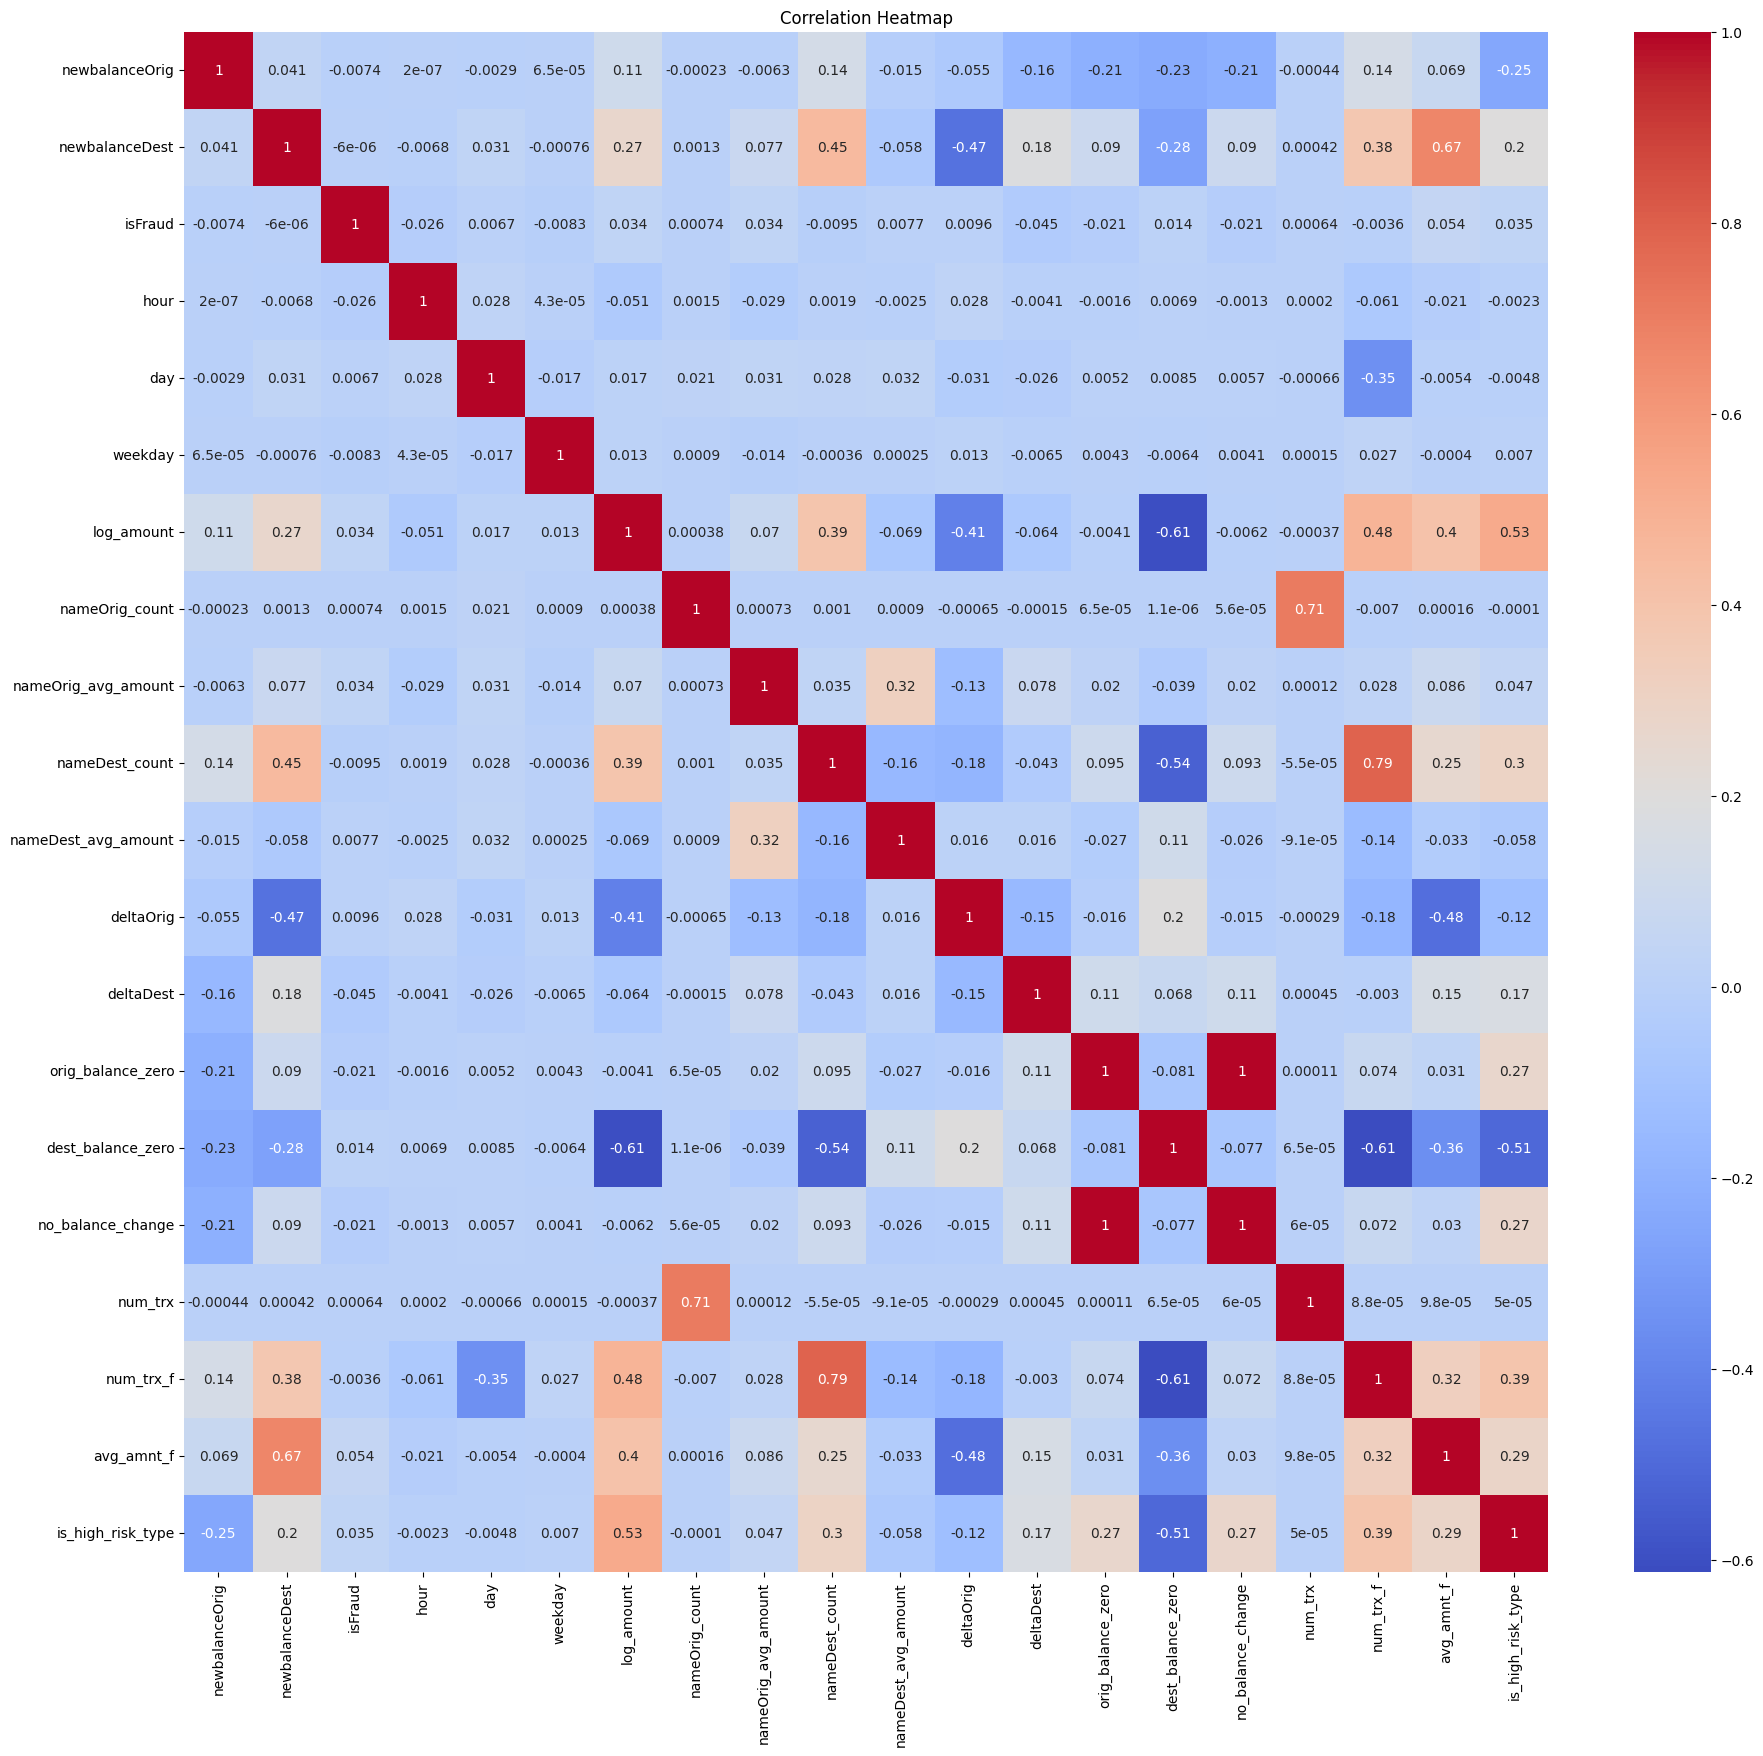

In [47]:
plt.figure(figsize=(22,20))
sns.heatmap(file3.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## **Model Training & Evaluation**
---

#### **Now, we need to split our dataset into x and y for training. We have observed that our dataset is quite large, highly imbalanced, which is a well-known fact for such a dataset and also some important features seem to be in correlation. So, to deal with such a situation, we will go with a tree-based algorithm like XGBoost, which also has inbuilt GPU support, so we don't have to use the cuML library as well.**

In [48]:
x=file3.drop(columns=['isFraud'])
y=file3['isFraud']

#### **As we know our dataset is highly imbalanced, so we will deal with that using the algorithmic method name '_weighted classification_', which will penalize rarely occurring events which will balance it in the algorithm label when performing mathematical caculations.**

In [49]:
fraud_count = y.sum()
legit_count = len(y) - fraud_count
cw = legit_count / fraud_count
print(f"Calculated scale_pos_weight: {cw:.4f}")

Calculated scale_pos_weight: 1079.7389


#### **Now, lets initialize our XGBoost classification algorithm and the scoring method we would like to choose to evaluate our model.**

In [50]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, precision_score, recall_score, f1_score

model=XGBClassifier(tree_method='hist', device='gpu', use_label_encoder=False, scale_pos_weight=cw, random_state=42)

def evaluate_model(model, x, y):
    pred=model.predict(x)
    proba=model.predict_proba(x)[:,1]

    metrics= {
        "Accuracy": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "ROC-AUC": roc_auc_score(y, proba),
        "PR-AUC": average_precision_score(y, proba),
        "Precision": precision_score(y, pred),
        "Recall": recall_score(y, pred)
    }
    return metrics

#### **Now, we have a datetime column which makes it a time series like dataset which is also highly imbalanced so normal cross validation (cv) method will lead to data leakage and it ll give us out of the box result wihich ll be very much impractical. So, to avoid such casses lets perform cv with '_TimeSeriesSplit_' and train the data.**

In [51]:
from sklearn.model_selection import TimeSeriesSplit

split=5
times_cv=TimeSeriesSplit(n_splits=split)
results=[]
fixed_train_size = 1000000

for fold, (train_idx, val_idx) in enumerate (times_cv.split(x, y)):

    train_idx = train_idx[-fixed_train_size:]
    print(f"\n--- Fold {fold+1}/{split}---")
    print(f"Training set size: {len(train_idx)} samples")
    if len(train_idx) > 0:
        print(f"Index of the first training sample: {train_idx[0]}")
    
    x_train, x_val=x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val=y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=1)
    metrics=evaluate_model(model, x_val, y_val)
    results.append(metrics)
    print(f" Fold {fold+1} metrics:")
    for metric, score in metrics.items():
        print(f"{metric}:{score:.4f}")

results_df=pd.DataFrame(results)


--- Fold 1/5---
Training set size: 1000000 samples
Index of the first training sample: 10671
[0]	validation_0-logloss:0.29049
[1]	validation_0-logloss:0.20813
[2]	validation_0-logloss:0.15147
[3]	validation_0-logloss:0.11161
[4]	validation_0-logloss:0.08371
[5]	validation_0-logloss:0.06344
[6]	validation_0-logloss:0.04865
[7]	validation_0-logloss:0.03850
[8]	validation_0-logloss:0.03061
[9]	validation_0-logloss:0.02428
[10]	validation_0-logloss:0.01910
[11]	validation_0-logloss:0.01486
[12]	validation_0-logloss:0.01184
[13]	validation_0-logloss:0.00978
[14]	validation_0-logloss:0.00812
[15]	validation_0-logloss:0.00703
[16]	validation_0-logloss:0.00607
[17]	validation_0-logloss:0.00534
[18]	validation_0-logloss:0.00446
[19]	validation_0-logloss:0.00412
[20]	validation_0-logloss:0.00378
[21]	validation_0-logloss:0.00352
[22]	validation_0-logloss:0.00328
[23]	validation_0-logloss:0.00296
[24]	validation_0-logloss:0.00263
[25]	validation_0-logloss:0.00248
[26]	validation_0-logloss:0.0023

#### **We are done with training, now, lets check how well our model has learned about our dataset.**

In [52]:
print("\n\n--- Average score---")
print(results_df.mean().to_frame(name='Average Score'))



--- Average score---
           Average Score
Accuracy        0.999866
F1              0.926273
ROC-AUC         0.998959
PR-AUC          0.979685
Precision       0.906628
Recall          0.948526


## **Prediction**
---

#### **We have observed that our model has learned things close to perfection; so, now check if it really performs that well we will test it on unknown test data. So, we will let it pass through the functions which we have created during Feature Engineering and later split it into x and y making the dataset completly unknown for our model.**

In [53]:
df=test.copy()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,datetime
6064026,504,CASH_OUT,262678.53,C1216671275,262678.53,0.0,C1747817225,577129.04,839807.57,1,2010-01-22
6064027,504,TRANSFER,219278.81,C1107477281,219278.81,0.0,C1615965100,0.00,0.00,1,2010-01-22
6064028,504,CASH_OUT,219278.81,C1874877556,219278.81,0.0,C2097103123,22127.85,241406.66,1,2010-01-22
6064029,504,TRANSFER,138048.52,C1877863116,138048.52,0.0,C1533281477,0.00,0.00,1,2010-01-22
6064030,504,TRANSFER,262678.53,C678590002,262678.53,0.0,C1721123505,0.00,0.00,1,2010-01-22


In [54]:
df1=datetime_component(df, datetime_col='datetime')

df1=some_new_features(df1, amount_col='amount', orig_col='nameOrig', dest_col='nameDest', old_orig_bal='oldbalanceOrg', new_orig_bal='newbalanceOrig', old_dest_bal='oldbalanceDest', new_dest_bal='newbalanceDest')

df1=risk_type(df1, main_col='type', high_risk=['TRANSFER', 'CASH_OUT'])

In [55]:
xx=df1.drop(columns=['isFraud'])
yy=df1['isFraud']

In [56]:
xx

,newbalanceOrig,newbalanceDest,hour,day,weekday,log_amount,nameOrig_count,nameOrig_avg_amount,nameDest_count,nameDest_avg_amount,deltaOrig,deltaDest,orig_balance_zero,dest_balance_zero,no_balance_change,num_trx,num_trx_f,avg_amnt_f,is_high_risk_type
1689,0.0,138048.52,0,22,4,11.835368,0,3018810.85,0,3018810.85,0.0,0.000000e+00,0,1,0,1,1,138048.520,1
1680,0.0,839807.57,0,22,4,12.478690,0,0.00,0,0.00,0.0,-1.164153e-10,0,0,0,1,2,309664.395,1
1681,0.0,0.00,0,22,4,12.298104,0,262678.53,0,262678.53,0.0,-2.192788e+05,0,1,0,1,1,219278.810,1
1682,0.0,241406.66,0,22,4,12.298104,0,219278.81,0,219278.81,0.0,0.000000e+00,0,0,0,1,1,219278.810,1
1683,0.0,0.00,0,22,4,11.835368,0,219278.81,0,219278.81,0.0,-1.380485e+05,0,1,0,1,1,138048.520,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297905,0.0,6379898.11,23,31,6,15.657870,0,850002.52,0,850002.52,0.0,-1.000000e-02,0,0,0,1,1,6311409.280,1
296483,0.0,0.00,23,31,6,14.045685,0,1258818.82,0,1258818.82,0.0,-1.258819e+06,0,1,0,1,1,1258818.820,1
296482,0.0,1762283.33,23,31,6,14.045685,0,339682.13,0,339682.13,0.0,1.000000e-02,0,0,0,1,1,1258818.820,1
297731,0.0,0.00,23,31,6,12.735768,0,6311409.28,0,6311409.28,0.0,-3.396821e+05,0,1,0,1,1,339682.130,1


#### **Now, lets make the prediction using the trained model on test data. lets see if it can perform close to what it has learn.**

In [57]:
y_pred = model.predict(xx)
y_proba = model.predict_proba(xx)[:, 1]

results= {'XGBClassifier':{
    "Accuracy": accuracy_score(yy, y_pred),
    "F1": f1_score(yy, y_pred),
    "ROC-AUC": roc_auc_score(yy, y_proba),
    "PR-AUC": average_precision_score(yy, y_proba),
    "Precision": precision_score(yy, y_pred),
    "Recall": recall_score(yy, y_pred)
}}
cv_scores_df = pd.DataFrame(results).T 
cv_scores_df

,Accuracy,F1,ROC-AUC,PR-AUC,Precision,Recall
XGBClassifier,0.99928,0.95735,0.999475,0.989294,0.98934,0.927364


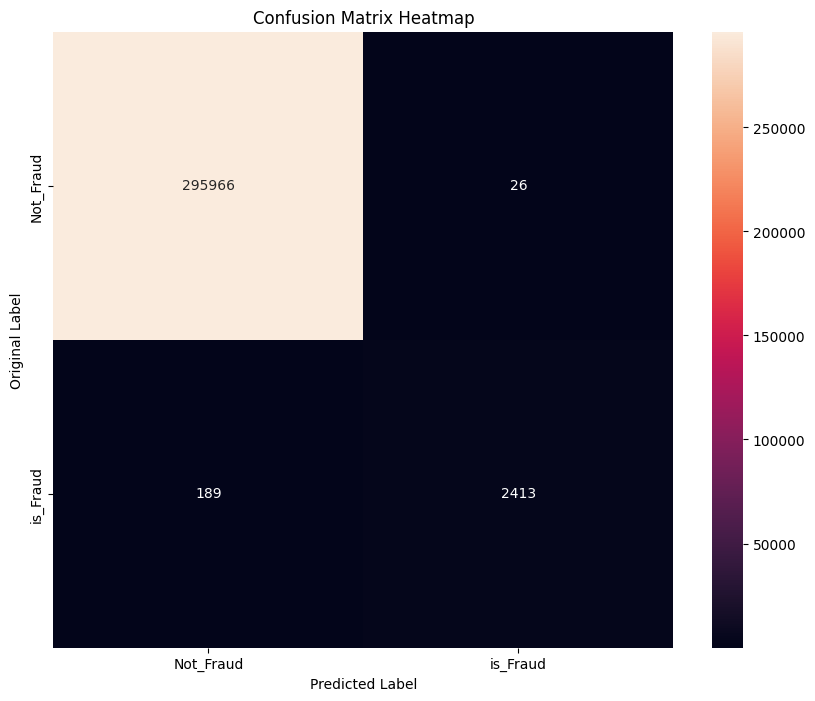

In [58]:
from sklearn.metrics import confusion_matrix,precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
class_names=['Not_Fraud', 'is_Fraud']
sns.heatmap(confusion_matrix(yy, y_pred), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Original Label')
plt.show()

In [59]:
prec, rec, thr=precision_recall_curve(yy, y_pred)
avg_prec=average_precision_score(yy, y_proba)

plt.plot(rec, prec, label==f"ap={avg_prec:.3f}")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='best')
plt.show()

NameError: name 'label' is not defined